---

# <center>★ AI / ML Research Implementation - Xception ★

<center><img src="https://raw.githubusercontent.com/Masterx-AI/Xception_Implementation/main/xception.jpg" style="width: 600px;"/>

---

### Objective:
- Understand the Model Architecture
- Reconstruct the Model Architecture from scratch
- Perform a dry run test to assess it's implemenation on real-time data.

---

### Xception Model Description:

onvolutional Neural Networks (CNN) have come a long way, from the LeNet-style, AlexNet, VGG models, which used simple stacks of convolutional layers for feature extraction and max-pooling layers for spatial sub-sampling, stacked one after the other, to Inception and ResNet networks which use skip connections and multiple convolutional and max-pooling blocks in each layer. Since its introduction, one of the best networks in computer vision has been the Inception network. The Inception model uses a stack of modules, each module containing a bunch of feature extractors, which allow them to learn richer representations with fewer parameters.

Xception paper — https://arxiv.org/abs/1610.02357

The Xception module has 3 main parts. The Entry flow, the Middle flow (which is repeated 8 times), and the Exit flow.


Entry flow of the Xception architecture (Source: Image from the original paper)
The entry flow has two blocks of convolutional layer followed by a ReLU activation. The diagram also mentions in detail the number of filters, the filter size (kernel size), and the strides.

There are also various Separable convolutional layers. There are also Max Pooling layers. When the strides are different than one, the strides are also mentioned. There are also Skip connections, where we use ‘ADD’ to merge the two tensors. It also shows the shape of the input tensor in each flow. For example, we begin with an image size of 299x299x3, and after the entry flow, we get an image size of 19x19x728.


Middle and Exit flow of Xception architecture (Source: Image from the original paper)
Similarly, for the Middle flow and the Exit flow, this diagram clearly explains the image size, the various layers, the number of filters, the shape of filters, the type of pooling, the number of repetitions, and the option of adding a fully connected layer in the end.

Also, all Convolutional and Separable Convolutional layers are followed by batch normalization.

---

## <center> Stractegic Plan of Action:
    
**We aim to solve the problem statement by creating a plan of action, Here are some of the necessary steps:**
1. Dataset Prepration
2. Model Development
3. Model Testing
4. Project Outcomes & Conclusion

---

## <center> 1. Dataset Prepration

In [1]:
#Importing the basic librarires

import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

# Preparing the dataset
(train_images, train_labels), (test_images, test_labels) = keras.datasets.cifar10.load_data()
CLASS_NAMES= ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Preparing the dataset
validation_images, validation_labels = train_images[:5000], train_labels[:5000]
train_images, train_labels = train_images[5000:], train_labels[5000:]

# Building tensorflow datasets
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
validation_ds = tf.data.Dataset.from_tensor_slices((validation_images, validation_labels))

170508288/170498071 [==============================] - 6s 0us/step


2022-06-26 16:48:32.726863: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [2]:
def process_images(image, label):
    # Normalize images to have a mean of 0 and standard deviation of 1
    image = tf.image.per_image_standardization(image)
    image = tf.image.resize(image, (299,299))
    return image, label

train_ds_size = tf.data.experimental.cardinality(train_ds).numpy()
test_ds_size = tf.data.experimental.cardinality(test_ds).numpy()
validation_ds_size = tf.data.experimental.cardinality(validation_ds).numpy()

train_ds = (train_ds
                  .map(process_images)
                  .shuffle(buffer_size=train_ds_size)
                  .batch(batch_size=32, drop_remainder=True))
test_ds = (test_ds
                  .map(process_images)
                  .shuffle(buffer_size=train_ds_size)
                  .batch(batch_size=32, drop_remainder=True))
validation_ds = (validation_ds
                  .map(process_images)
                  .shuffle(buffer_size=train_ds_size)
                  .batch(batch_size=32, drop_remainder=True))

---

## <center>2. Model Development

In [3]:
# Building the Xception Model Architecture

def entry_flow(inputs):

    x = layers.Conv2D(32, 3, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(64, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for size in [128, 256, 728]:
        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(size, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(size, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

        residual = layers.Conv2D(  # Project residual
            size, 1, strides=2, padding='same')(previous_block_activation)           
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    return x


def middle_flow(x, num_blocks=8):
  
    previous_block_activation = x

    for _ in range(num_blocks):
        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(728, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(728, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(728, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.add([x, previous_block_activation])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    return x


def exit_flow(x, num_classes=1000):
  
    previous_block_activation = x

    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(728, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(1024, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    residual = layers.Conv2D(  # Project residual
      1024, 1, strides=2, padding='same')(previous_block_activation)
    x = layers.add([x, residual])  # Add back residual

    x = layers.SeparableConv2D(1536, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.SeparableConv2D(2048, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 1:
        activation = 'sigmoid'
    else:
        activation = 'softmax'
    return layers.Dense(num_classes, activation=activation)(x)

In [4]:
# Building the Xception Model Architecture

inputs = keras.Input(shape=(299, 299, 3))
outputs = exit_flow(middle_flow(entry_flow(inputs)))
model = keras.Model(inputs, outputs)

# Compiling the Model
model.compile(optimizer='adam', loss=keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])

# Checking Model Summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 150, 150, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 150, 150, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 150, 150, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

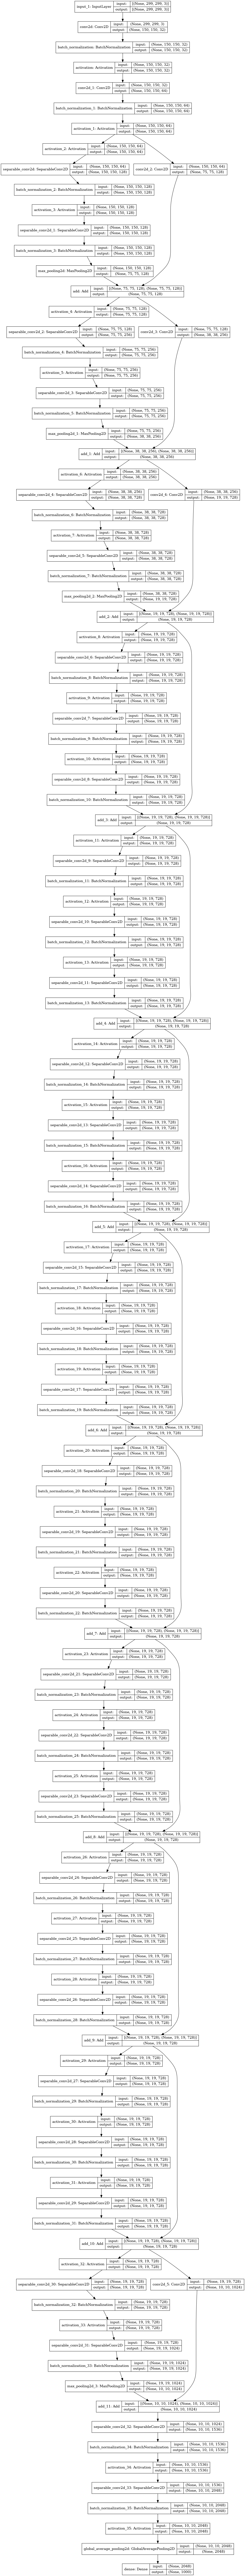

In [5]:
# Plotting the model architecture

plot_model(model, to_file="my_model.png", show_shapes=True)

---

## <center>3. Model Testing

In [6]:
# Moddel Training

# hisroty = model.fit(train_ds,
#                     epochs=5,
#                     validation_data=validation_ds,
#                     validation_freq=1)

### COMMENTING THE TRAINING CODE AS IT THROWS MEMORY ALLOCATION ERROR

In [7]:
# Model Evaluation

# model.evaluate(test_x, test_y)

---

# <center>4. Project Outcomes & Conclusion

### Here are some of the key outcomes of the project:

- The Model Architecture was reconstructed from scratch with no errors.
- We were able to plot the model graph & observe input & output shapes of all the layers. 
- Also we could identify that the total trainable paramters for the Xception model were 22.8M.
- To demonstrate it's functionality, we have tested the model for just 5 epochs (due to hardware limitations). 
- Despite this, the model has performed surpisingly well achieving high accuracy within few iterations.

In [8]:
#<<<--------------------------------------THE END---------------------------------------->>>